# Monet by Me- A Introduction to Building and Training a GAN Network. 

## 1. Deep Learning Problem Description:
- Brief explanation of GANs and their use in image generation.
- Overview of the dataset and the MiFID evaluation metric.
## 2. Exploratory Data Analysis (EDA):
- Load and visualize the dataset.
- Analyze image statistics (e.g., dimensions, color channels).
## 3. Analysis (Model Building and Training):
- Build a basic Generative Adversarial Network (GAN).
- Use TensorFlow/Keras.
- Train the model on the given dataset.
## 4. Results:
- Generate new images using the trained model.
- Compute MiFID score (as explained in the competition).
## 5. Discussion/Conclusions:
- Discuss model performance and the generated image quality.
- Suggest improvements.

---

### Step 1: Introduction to the Deep Learning Project and Dataset

This project focuses on applying deep learning techniques, specifically **Generative Adversarial Networks (GANs)**, to create Monet-style artwork from real-world photographs. GANs were introduced by Ian Goodfellow in 2014 and since have become a cornerstone of generative modeling, enabling the synthesis of realistic and artistic images across domains. 

#### Motivation and Background

The motivation behind this project lies in the artistic and technical challenges posed by generative modeling. Monet, a master of the Impressionist movement, is known for his vivid, textured, and dreamlike representations of landscapes. This project not only enhances my understanding of GAN architectures but also aligns with a broader interest in exploring the intersection of art and machine learning.

#### Dataset Overview

The dataset for this project is sourced from the [Kaggle GAN Getting Started Competition](https://www.kaggle.com/competitions/gan-getting-started/overview). It consists of two primary components:

1. **Monet Images**: A collection of 300 Monet-style paintings in JPEG format.
2. **Photo Images**: Over 7,000 landscape photographs that serve as the base input for style transformation.

These datasets are provided as both raw image files and preprocessed TensorFlow TFRecords for efficient loading. Participants are tasked with training a CycleGAN model to transform photo images into Monet-style paintings, a challenge that tests the ability of GANs to capture and replicate intricate artistic patterns.

#### Objectives

The primary goal of this project is to generate Monet-style artwork that closely resembles the characteristics of the original paintings. By focusing on optimizing GAN performance through hyperparameter tuning and training methods, the project aims to produce visually appealing results while scoring competitively on the Kaggle leaderboard. In addition to technical learning, this project serves as a creative exploration of how machine learning can reinterpret and mimic iconic artistic styles.

In [27]:
import numpy as np
import pandas as pd
import os

# Check and list the contents of the input directory
input_path = '/kaggle/input'

print("Contents of input directory:")
for dirname, subdirs, filenames in os.walk(input_path):
    print(f"Directory: {dirname}")
    print(f"Subdirectories: {subdirs}")
    print(f"Number of files: {len(filenames)}")
    if filenames:
        print(f"Example file: {filenames[0]}")

Contents of input directory:
Directory: /kaggle/input
Subdirectories: ['gan-getting-started']
Number of files: 0
Directory: /kaggle/input/gan-getting-started
Subdirectories: ['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']
Number of files: 0
Directory: /kaggle/input/gan-getting-started/monet_jpg
Subdirectories: []
Number of files: 300
Example file: f4413e97bd.jpg
Directory: /kaggle/input/gan-getting-started/photo_tfrec
Subdirectories: []
Number of files: 20
Example file: photo12-352.tfrec
Directory: /kaggle/input/gan-getting-started/photo_jpg
Subdirectories: []
Number of files: 7038
Example file: fb97febc5f.jpg
Directory: /kaggle/input/gan-getting-started/monet_tfrec
Subdirectories: []
Number of files: 5
Example file: monet12-60.tfrec


### Connecting to the Dataset, Viewing Sample Images

This cell imports necessary libraries, sets the dataset directories for Monet-style and real photo images, and loads image file paths. It defines a function to display a specified number of images and uses it to visualize sample Monet-style images and real photos side by side.

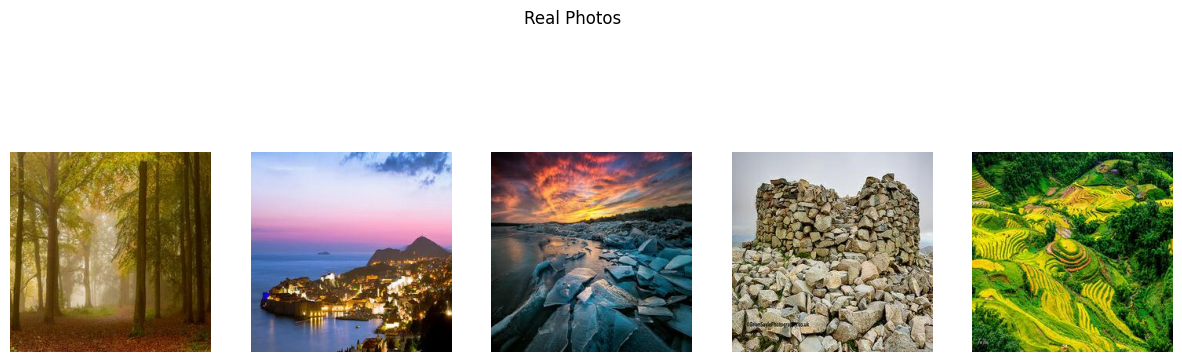

In [28]:
import cv2
import matplotlib.pyplot as plt
import glob

# Set dataset directories
monet_dir = os.path.join(input_path, 'gan-getting-started/monet_jpg')
photo_dir = os.path.join(input_path, 'gan-getting-started/photo_jpg')

# Load sample Monet and photo images
monet_images = glob.glob(os.path.join(monet_dir, "*.jpg"))
photo_images = glob.glob(os.path.join(photo_dir, "*.jpg"))

# Display sample images
def show_images(image_paths, title, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize a few Monet and photo images
show_images(monet_images, "Monet-style Images")
show_images(photo_images, "Real Photos")

# Step 2: Explortory Data Analysis (EDA)

This cell loads and preprocesses the Monet and photo datasets from TFRecord files. It defines functions to decode, normalize, and parse images, as well as a function to visualize a sample of images. The datasets are prepared with batching and prefetching for efficient training, and sample images are displayed to confirm proper loading and preprocessing.

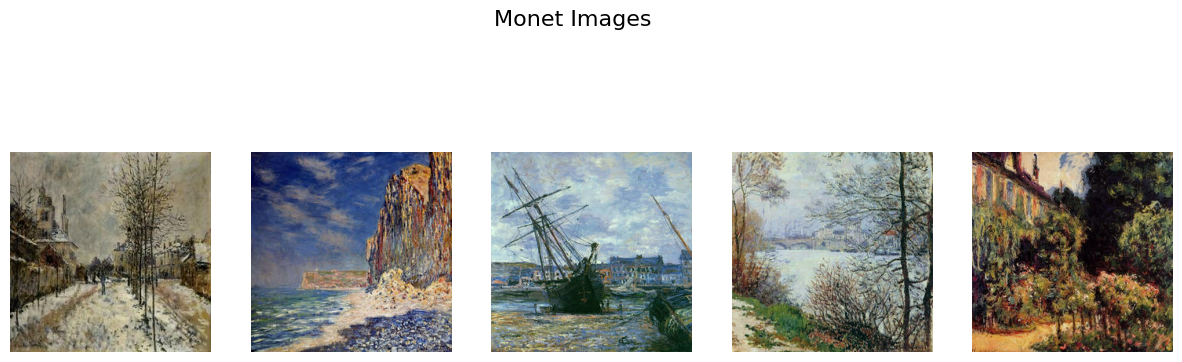

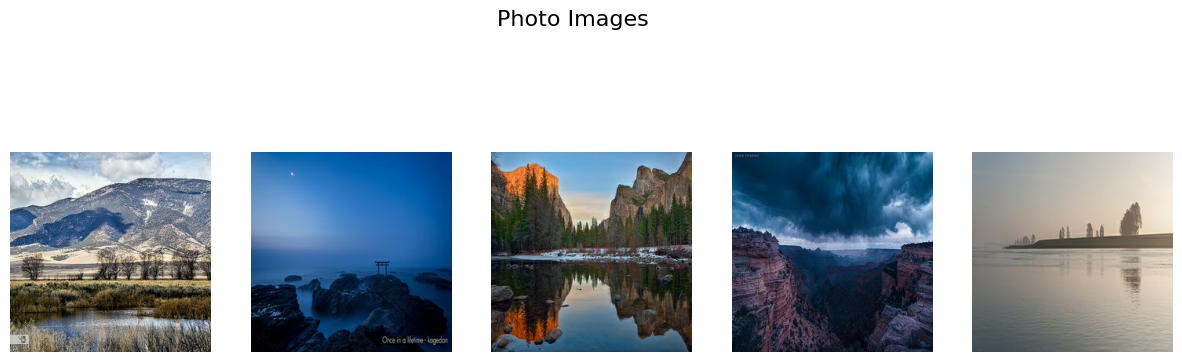

In [29]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Load the dataset paths
data_dir = '/kaggle/input/gan-getting-started'
monet_tfrecord = os.path.join(data_dir, 'monet_tfrec/*.tfrec')
photo_tfrecord = os.path.join(data_dir, 'photo_tfrec/*.tfrec')

# Define a function to parse TFRecords
def decode_image(image):
    """Decode and preprocess the image."""
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def parse_tfrecord(example):
    """Parse TFRecord example."""
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example['image'])
    return image

# Load the dataset from TFRecords
def load_dataset(tfrecord_path):
    """Load and prepare the dataset."""
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecord_path))
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(16).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load Monet and photo datasets
monet_dataset = load_dataset(monet_tfrecord)
photo_dataset = load_dataset(photo_tfrecord)

# Visualize sample images
def visualize_dataset(dataset, title, n=5):
    """Visualize n sample images from the dataset."""
    plt.figure(figsize=(15, 5))
    for i, image_batch in enumerate(dataset.take(1)):  # Take a single batch
        for j in range(min(n, len(image_batch))):
            plt.subplot(1, n, j+1)
            img = (image_batch[j].numpy() * 127.5 + 127.5).astype(int)  # Rescale to [0, 255]
            plt.imshow(img)
            plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize some images
visualize_dataset(monet_dataset, "Monet Images")
visualize_dataset(photo_dataset, "Photo Images")


# Step 3. Analysis (Modeling and Building)

This cell defines and builds the Generator model for a CycleGAN architecture. The model includes downsampling and upsampling layers to transform images, using `Conv2D` for encoding and `Conv2DTranspose` for decoding.

Two generators are created: one to transform photos into Monet-style images and another to transform Monet-style images into photos. The model summaries are displayed for verification.

In [30]:
import tensorflow as tf
from tensorflow.keras import layers

def build_generator():
    """Define the Generator model."""
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(x)
    
    # Upsampling
    x = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)

# Create generator models
generator_g = build_generator()  # Photo -> Monet
generator_f = build_generator()  # Monet -> Photo

generator_g.summary()
generator_f.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,547 (1.02 MB)

 Trainable params: 268,547 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,547 (1.02 MB)

 Trainable params: 268,547 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

### Define Discriminator Model
This cell defines and builds the Discriminator model for a CycleGAN architecture. The model uses convolutional layers to extract features, followed by a dense layer with a sigmoid activation to classify images as real or generated. Two discriminators are created: one to distinguish real Monet-style images from generated ones and another for real photos versus generated photos. Model summaries are displayed for verification.

In [31]:
def build_discriminator():
    """Define the Discriminator model."""
    inputs = layers.Input(shape=[256, 256, 3])

    # Convolutional layers
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (4, 4), strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, x)

# Create discriminator models
discriminator_x = build_discriminator()  # Monet or generated Monet
discriminator_y = build_discriminator()  # Photo or generated Photo

discriminator_x.summary()
discriminator_y.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,625 (2.51 MB)

 Trainable params: 658,625 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,625 (2.51 MB)

 Trainable params: 658,625 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

### Loss Function for CycleGAN
This cell defines the loss functions for training the CycleGAN:

- **Adversarial Loss**: Encourages the generator to produce realistic images, calculated using binary cross-entropy.
- **Generator Loss**: Penalizes the generator when the discriminator identifies generated images as fake.
- **Discriminator Loss**: Combines the losses for correctly classifying real and fake images.
- **Cycle Consistency Loss**: Ensures that an image transformed and then cycled back retains its original structure.
- **Identity Loss**: Ensures the generator preserves the identity of the input when generating images of the same domain.

In [32]:
# Loss functions
adv_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return adv_loss_fn(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = adv_loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = adv_loss_fn(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

### Adding a Learning Rate: Specifying Decay Steps
This cell calculates the total number of steps for learning rate decay during training. It sets the dataset size, batch size, and the number of epochs over which the learning rate decays. The number of steps per epoch and total decay steps are computed, and the decay steps are printed for reference.

In [33]:
# Dataset size and batch size
dataset_size = 7000
batch_size = 16
decay_epochs = 35

# Steps per epoch and total decay steps
steps_per_epoch = dataset_size // batch_size
decay_steps = steps_per_epoch * decay_epochs

print(f"Decay Steps: {decay_steps}")

Decay Steps: 15295


### Optimization
This cell defines the training optimizers, learning rate schedule, and the main training step function for the CycleGAN model:

- **Learning Rate Schedule**: A polynomial decay schedule is used for some optimizers, with a constant rate for 15 epochs followed by linear decay.
- **Optimizers**: Adam optimizers are defined for the generators and discriminators with a learning rate and momentum parameter `beta_1`.
- **Training Step Function**: Implements the forward and backward passes for one training step. It calculates losses for:
  - Generators: Adversarial, cycle consistency, and identity losses.
  - Discriminators: Losses for distinguishing real and generated images.
  The function applies gradients to update model weights using the respective optimizers.

In [34]:
# Optimizers

# Learning rate schedule: constant for 15 epochs, then linearly decay
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=2e-4,
    decay_steps= 15295,  
    end_learning_rate=0.0
)

# Apply the schedule to optimizers
gen_g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
disc_x_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)

#gen_g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
gen_f_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
#disc_x_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_y_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# # Discriminator loss weighting
# discriminator_loss_weight = 0.5

# def combined_discriminator_loss(real_output, fake_output):
#     real_loss = adv_loss_fn(tf.ones_like(real_output), real_output)
#     fake_loss = adv_loss_fn(tf.zeros_like(fake_output), fake_output)
#     return discriminator_loss_weight * (real_loss + fake_loss)

@tf.function
def train_step(real_x, real_y):
    # Train generators
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)  # Photo -> Monet
        fake_x = generator_f(real_y, training=True)  # Monet -> Photo

        # Cycle consistency
        cycled_x = generator_f(fake_y, training=True)  # Monet -> Photo -> Monet
        cycled_y = generator_g(fake_x, training=True)  # Photo -> Monet -> Photo

        # Identity mapping
        same_x = generator_f(real_x, training=True)  # Photo -> Photo
        same_y = generator_g(real_y, training=True)  # Monet -> Monet

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        #cycle_loss_weight = 10.0  # New variable to weight cycle consistency loss

        #total_gen_g_loss = gen_g_loss + cycle_loss_weight * total_cycle_loss + identity_loss(real_y, same_y)
        #total_gen_f_loss = gen_f_loss + cycle_loss_weight * total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
        # Discriminator losses (using the new combined discriminator loss function)
        #disc_x_loss = combined_discriminator_loss(disc_real_x, disc_fake_x)
        #disc_y_loss = combined_discriminator_loss(disc_real_y, disc_fake_y)


    # Apply gradients
    gradients_of_gen_g = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gradients_of_gen_f = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    gradients_of_disc_x = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    gradients_of_disc_y = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    gen_g_optimizer.apply_gradients(zip(gradients_of_gen_g, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gradients_of_gen_f, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(gradients_of_disc_x, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(gradients_of_disc_y, discriminator_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

### First training adjustments
This cell defines a training loop for the CycleGAN model, iterating over the specified number of epochs. For each epoch, it trains the model on batches of paired photo and Monet-style images using the `train_step` function. After each epoch, it prints the generator and discriminator losses to monitor training progress.

This step was commented out after it was decided to visualize the data to watch how the loss values change over time and compare model to model. 

In [35]:
# EPOCHS = 50
# for epoch in range(EPOCHS):
#     for real_x, real_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
#         g_loss, f_loss, dx_loss, dy_loss = train_step(real_x, real_y)
#     print(f"Epoch {epoch + 1}: G_loss={g_loss}, F_loss={f_loss}, DX_loss={dx_loss}, DY_loss={dy_loss}")

### Main Training Loop--Adjusted Nuber of Epochs
This cell implements the main training loop for 75 epochs, tracking and averaging loss values for both generators and discriminators across batches:

- **Loss Tracking**: Initializes lists to store generator and discriminator losses for each epoch.
- **Training**: Iterates through paired photo and Monet-style image batches, calling `train_step` to compute losses.
- **Averaging**: Calculates the average loss for each component over all batches in the epoch.
- **Logging**: Appends average losses to their respective lists and prints a summary of the losses for each epoch to monitor training progress.

In [36]:
# Initialize lists to store loss values
G_losses = []  # Generator G (Photo -> Monet)
F_losses = []  # Generator F (Monet -> Photo)
DX_losses = []  # Discriminator DX (Monet)
DY_losses = []  # Discriminator DY (Photo)

EPOCHS = 75

for epoch in range(EPOCHS):
    epoch_g_loss = 0
    epoch_f_loss = 0
    epoch_dx_loss = 0
    epoch_dy_loss = 0
    batch_count = 0
    
    # Loop through batches
    for real_x, real_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
        g_loss, f_loss, dx_loss, dy_loss = train_step(real_x, real_y)
        
        # Accumulate losses
        epoch_g_loss += g_loss
        epoch_f_loss += f_loss
        epoch_dx_loss += dx_loss
        epoch_dy_loss += dy_loss
        batch_count += 1

    # Average the losses over the number of batches
    G_losses.append(epoch_g_loss / batch_count)
    F_losses.append(epoch_f_loss / batch_count)
    DX_losses.append(epoch_dx_loss / batch_count)
    DY_losses.append(epoch_dy_loss / batch_count)

    # Print epoch summary
    print(f"Epoch {epoch + 1}: "
          f"G_loss={G_losses[-1]:.4f}, F_loss={F_losses[-1]:.4f}, "
          f"DX_loss={DX_losses[-1]:.4f}, DY_loss={DY_losses[-1]:.4f}")

Epoch 1: G_loss=2.1113, F_loss=2.1714, DX_loss=0.6731, DY_loss=0.6569
Epoch 2: G_loss=3.3572, F_loss=3.1673, DX_loss=0.3053, DY_loss=0.3153
Epoch 3: G_loss=4.3489, F_loss=4.7183, DX_loss=0.0708, DY_loss=0.7620
Epoch 4: G_loss=3.9637, F_loss=4.8294, DX_loss=0.5206, DY_loss=1.7303
Epoch 5: G_loss=3.8627, F_loss=5.6975, DX_loss=0.6756, DY_loss=1.1683
Epoch 6: G_loss=4.8327, F_loss=10.2504, DX_loss=0.6995, DY_loss=0.7226
Epoch 7: G_loss=5.3376, F_loss=6.6676, DX_loss=0.6931, DY_loss=0.8565
Epoch 8: G_loss=5.3403, F_loss=14.4702, DX_loss=0.2252, DY_loss=0.5419
Epoch 9: G_loss=4.2003, F_loss=14.3489, DX_loss=0.8616, DY_loss=0.2675
Epoch 10: G_loss=5.6119, F_loss=10.7717, DX_loss=0.3870, DY_loss=0.5277
Epoch 11: G_loss=4.5540, F_loss=7.8228, DX_loss=0.1250, DY_loss=0.7166
Epoch 12: G_loss=5.5561, F_loss=12.7984, DX_loss=0.3056, DY_loss=1.1822
Epoch 13: G_loss=3.8543, F_loss=8.6236, DX_loss=0.0584, DY_loss=0.5209
Epoch 14: G_loss=5.9981, F_loss=11.6379, DX_loss=0.2129, DY_loss=0.2810
Epoch 15:

### Visualize the Loss Trends--Make Adjustments
This cell visualizes the loss trends during CycleGAN training by plotting the generator and discriminator losses over epochs. It creates a line plot for each loss type (Generator G, Generator F, Discriminator DX, Discriminator DY) with markers for clarity, allowing for easy monitoring of training performance and convergence.

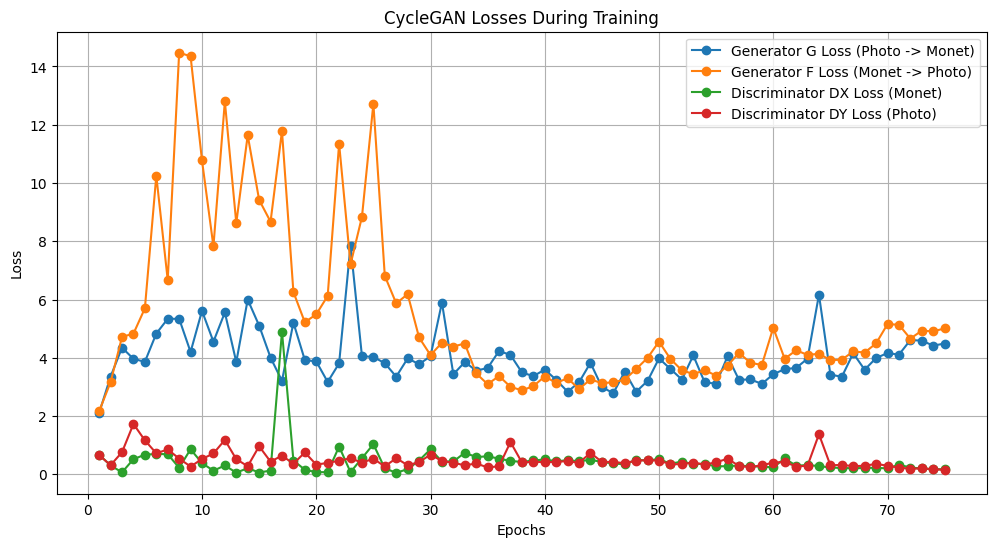

In [37]:
# Plot the losses from the training loop
import matplotlib.pyplot as plt

# Epoch numbers
epochs = list(range(1, len(G_losses) + 1))

# Create the loss plots
plt.figure(figsize=(12, 6))
plt.plot(epochs, G_losses, label='Generator G Loss (Photo -> Monet)', marker='o')
plt.plot(epochs, F_losses, label='Generator F Loss (Monet -> Photo)', marker='o')
plt.plot(epochs, DX_losses, label='Discriminator DX Loss (Monet)', marker='o')
plt.plot(epochs, DY_losses, label='Discriminator DY Loss (Photo)', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CycleGAN Losses During Training')
plt.legend()
plt.grid()
plt.show()


### View Sample Generated Images
This cell defines a function to generate and save images using a trained generator:

- **Input**: A generator model, a test dataset, the number of images to generate, and an optional output directory.
- **Functionality**: 
  - Iterates through the test dataset to generate images.
  - Rescales the generated images to the `[0, 255]` range and converts them to `uint8`.
  - Displays the generated images with titles and saves them as `.png` files in the specified directory.
- **Output**: Saves the generated images and provides a visual confirmation of the generator's performance.

In [38]:
def generate_and_save_images(generator, test_dataset, num_images=5, output_dir="./generated_images"):
    """Generate and save images using the generator."""
    os.makedirs(output_dir, exist_ok=True)
    for idx, photo_batch in enumerate(test_dataset.take(num_images)):
        # Generate the image using the generator
        generated_image = generator(photo_batch, training=False)[0].numpy()  # Take the first image in the batch
        generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0, 255] and convert to uint8

        # Display the generated image
        plt.imshow(generated_image)
        plt.axis("off")
        plt.title(f"Generated Monet Image {idx + 1}")
        plt.show()

        # Save the generated image
        plt.imsave(f"{output_dir}/generated_image_{idx + 1}.png", generated_image)

# Step 4: Results

### Visualize More Images
This cell generates six Monet-style image from a photo using the trained generator:

- **Image Generation**: Processes the first batch of photos and generates an image using the generator model.
- **Property Check**: Prints the shape and pixel value range of the generated image for verification.
- **Visualization**: Rescales the image to the `[0, 255]` range, converts it to `uint8`, and displays it with a title for a visual evaluation of the generator's performance.

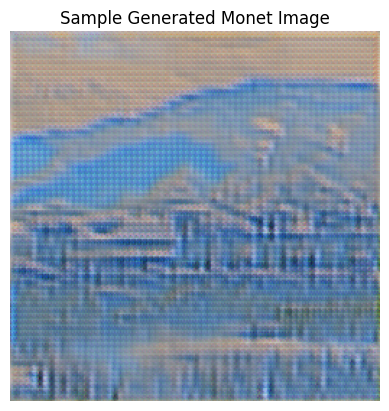

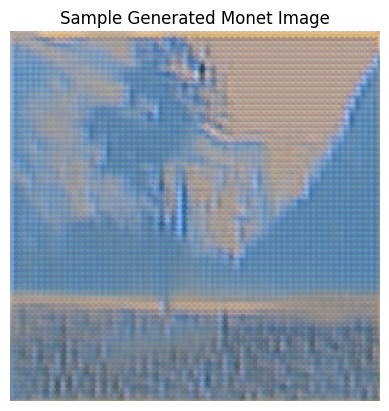

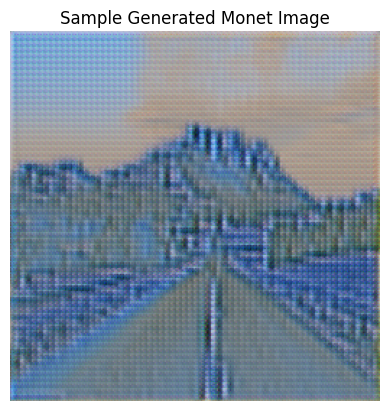

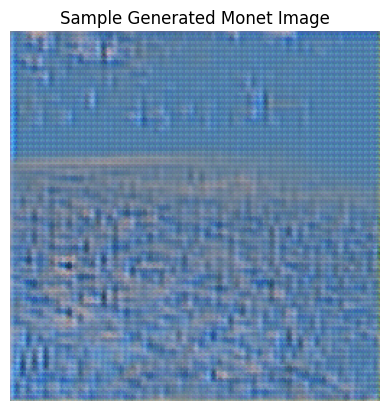

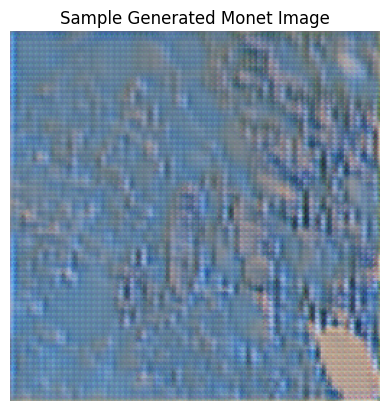

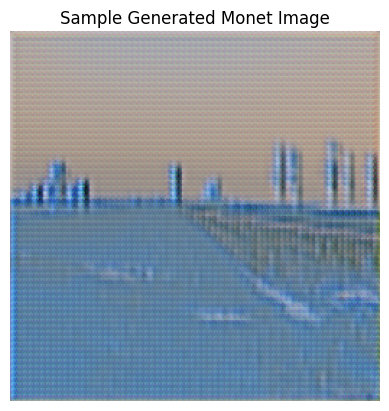

In [39]:
# Generate six image using the generator
for photo_batch in photo_dataset.take(6):  # Take the first batch
    generated_image = generator_g(photo_batch, training=False)[0].numpy()  # Generate the first image in the batch

    # Rescale and visualize the generated image
    generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(generated_image)
    plt.axis("off")
    plt.title("Sample Generated Monet Image")
    plt.show()

### First trial at Uploading Submission 
Keeping block for future reference. 

In [40]:
# import zipfile
# import os
# import numpy as np
# import tensorflow as tf

# # Directory for the output ZIP file
# output_zip_path = "/kaggle/working/images.zip"

# def generate_and_zip_images(generator, photo_dataset, num_images=7000, output_zip=output_zip_path):
#     """Generate Monet-style images and save them to a ZIP file."""
#     with zipfile.ZipFile(output_zip, "w") as zf:  # Create a ZIP archive
#         count = 0
#         for photo_batch in photo_dataset:
#             for photo in photo_batch:  # Iterate over individual images in the batch
#                 if count >= num_images:
#                     break  # Stop once the desired number of images is reached

#                 # Generate an image using the generator
#                 generated_image = generator(tf.expand_dims(photo, axis=0), training=False)[0].numpy()
#                 generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0, 255]

#                 # Convert the image to RGB format and save it directly to the ZIP file
#                 filename = f"monet_image_{count + 1}.jpg"
#                 with zf.open(filename, "w") as file:
#                     tf.io.write_file(filename, tf.image.encode_jpeg(generated_image))

#                 count += 1

#                 # Print progress every 1000 images
#                 if count % 1000 == 0:
#                     print(f"{count} images processed and added to the ZIP file.")

#             if count >= num_images:
#                 break  # Stop iterating through batches if the limit is reached

#     print(f"Generated {count} images successfully saved to {output_zip}")

### Test function
This cell defines a function to test saving a single generated image as a JPEG inside a ZIP file:

- **Input**: A generator model, a photo dataset, and the path for the output ZIP file.
- **Functionality**:
  - Takes the first batch from the photo dataset and processes the first image.
  - Generates a Monet-style image using the generator.
  - Rescales the image to the `[0, 255]` range and encodes it as a JPEG.
  - Writes the encoded image into a ZIP file with a specified filename.
- **Output**: Creates a ZIP file containing the generated image and provides status updates during the process.

In [41]:
import zipfile
import os
import numpy as np
import tensorflow as tf

# Directory for the output ZIP file
output_zip_path = "/kaggle/working/images.zip"

def test_zip_image(generator, photo_dataset, output_zip=output_zip_path):
    """Test saving a single Monet-style image to a ZIP file."""
    with zipfile.ZipFile(output_zip, "w") as zf:  # Create a ZIP archive
        for photo_batch in photo_dataset.take(1):  # Take one batch
            # Process only the first image in the batch
            photo = photo_batch[0]
            generated_image = generator(tf.expand_dims(photo, axis=0), training=False)[0].numpy()
            generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0, 255]

            # Save the image to the ZIP archive
            filename = "test_image.jpg"
            #print(f"Attempting to write {filename} to ZIP.")
            encoded_image = tf.io.encode_jpeg(generated_image).numpy()  # Encode the image as JPEG
            with zf.open(filename, "w") as file:
                file.write(encoded_image)  # Write the encoded image to the ZIP archive

            #print(f"{filename} written successfully!")
            break

    print(f"Test ZIP file created at {output_zip}")

# Run the test function
test_zip_image(generator_g, photo_dataset)

Test ZIP file created at /kaggle/working/images.zip


### Successful Output Function to Export Submission File!!
This cell defines a function to generate a large number of Monet-style images using a trained generator and save them in a ZIP file with detailed debugging:

- **Input**: A generator model, a photo dataset, the desired number of images, and the output ZIP file path.
- **Functionality**:
  - Iterates through the photo dataset in batches, generating Monet-style images for each photo.
  - Rescales the images to the `[0, 255]` range, encodes them as JPEGs, and writes them to a ZIP archive.
  - Includes detailed debug messages for each step, tracking batch processing, individual image generation, encoding, and saving.
  - Stops once the desired number of images is reached.
- **Output**: A ZIP file containing the generated images, with periodic progress updates and error handling to ensure smooth execution.

In [42]:
def generate_and_zip_images_debug(generator, photo_dataset, num_images=7000, output_zip=output_zip_path):
    """Generate Monet-style images and save them to a ZIP file with detailed debugging."""
    with zipfile.ZipFile(output_zip, "w") as zf:  # Create a ZIP archive
        count = 0
        print(f"Starting to generate {num_images} images...")

        for i, photo_batch in enumerate(photo_dataset):
            print(f"Processing batch {i + 1} with {len(photo_batch)} images")

            for j, photo in enumerate(photo_batch):
                if count >= num_images:
                    print(f"Reached {num_images} images. Stopping.")
                    break

                try:
                    # Generate the Monet-style image
                    #print(f"  Generating image {count + 1}...")
                    generated_image = generator(tf.expand_dims(photo, axis=0), training=False)[0].numpy()
                    generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)  # Rescale

                    # Encode and save to ZIP
                    filename = f"monet_image_{count + 1}.jpg"
                    encoded_image = tf.io.encode_jpeg(generated_image).numpy()
                    #print(f"  Writing {filename} to ZIP...")
                    with zf.open(filename, "w") as file:
                        file.write(encoded_image)

                    #print(f"  {filename} written successfully!")
                    count += 1

                except Exception as e:
                    print(f"Error processing image {j + 1} in batch {i + 1}: {e}")

                if count % 1000 == 0:
                    print(f"{count} images processed and added to ZIP.")

            if count >= num_images:
                print(f"Stopping at batch {i + 1}. Total images: {count}")
                break

        print(f"Generated {count} images successfully saved to {output_zip}")

### Run Function to Generate and Zip Files for Submission

In [43]:
generate_and_zip_images_debug(generator_g, photo_dataset, num_images=7000)

Starting to generate 7000 images...
Processing batch 1 with 16 images
  Generating image 1...
  Writing monet_image_1.jpg to ZIP...
  monet_image_1.jpg written successfully!
  Generating image 2...
  Writing monet_image_2.jpg to ZIP...
  monet_image_2.jpg written successfully!
  Generating image 3...
  Writing monet_image_3.jpg to ZIP...
  monet_image_3.jpg written successfully!
  Generating image 4...
  Writing monet_image_4.jpg to ZIP...
  monet_image_4.jpg written successfully!
  Generating image 5...
  Writing monet_image_5.jpg to ZIP...
  monet_image_5.jpg written successfully!
  Generating image 6...
  Writing monet_image_6.jpg to ZIP...
  monet_image_6.jpg written successfully!
  Generating image 7...
  Writing monet_image_7.jpg to ZIP...
  monet_image_7.jpg written successfully!
  Generating image 8...
  Writing monet_image_8.jpg to ZIP...
  monet_image_8.jpg written successfully!
  Generating image 9...
  Writing monet_image_9.jpg to ZIP...
  monet_image_9.jpg written successf

# Step 5: Discussion and Conclusions

### Discussion and Conclusion

This project marks a significant milestone as my first experience working with Generative Adversarial Networks (GANs) and image generation. With an overall score of **109**, I achieved **53rd place on the leaderboard**, which feels like a solid accomplishment for a first generative project. The results demonstrate the potential of GANs in style transfer tasks, though there are areas for improvement.

One of the key aspects of this project was **extensive hyperparameter tuning**. Some of the most impactful adjustments included:

- Incorporating a **learning rate scheduler** to control the training dynamics and achieve a more stable optimization process.
- Increasing the number of training epochs to allow the model more time to learn complex mappings between photo and Monet-style images.
- Experimenting with the **weight ratios of the generator and discriminator losses** to balance their contributions to the training process. Many of the commented-out lines in the code reflect this iterative process.

Despite these efforts, the generated images, while embodying Monet's style, tend to appear slightly **dull in color and blurred**, suggesting room for further refinement. This could be addressed by increasing the training time, exploring alternative architectures, or fine-tuning the loss functions.

One promising next step could involve transitioning to a **DaGAN model**. This architecture is known for its ability to generate more vibrant and detailed images, which could potentially improve the score and image quality. Additionally, **further hyperparameter optimization** and even more **training epochs** could help the model converge to better results.

Overall, this project has been an exciting and valuable learning experience. It not only provided insight into the inner workings of GANs but also demonstrated the challenges and rewards of fine-tuning generative models. Moving forward, I am eager to build on this foundation and explore advanced techniques to push the boundaries of image generation.
